In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

zip_path = "/content/drive/MyDrive/Densenet121.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

base_path = "/content/dataset/Densenet121"
train_dir = os.path.join(base_path, "Train")
val_dir   = os.path.join(base_path, "Validate")
test_dir  = os.path.join(base_path, "Test")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("✅ Number of classes detected:", num_classes)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(224, 224, 3))

# --- DenseNet121 branch ---
densenet = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in densenet.layers[:-40]:  # fine-tune last 40 layers
    layer.trainable = False
x1 = GlobalAveragePooling2D()(densenet.output)

# --- MobileNetV2 branch ---
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
for layer in mobilenet.layers[:-30]:
    layer.trainable = False
x2 = GlobalAveragePooling2D()(mobilenet.output)

# --- Combine features ---
combined = Concatenate()([x1, x2])
combined = Dropout(0.4)(combined)
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.3)(combined)

# Output layer
output = Dense(num_classes, activation='softmax')(combined)

# Build final model
model = Model(inputs=input_layer, outputs=output)
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-4193983479.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 9,887,624 (37.72 MB)

 Trainable params: 2,946,248 (11.24 MB)

 Non-trainable params: 6,941,376 (26.48 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ Compile the model first
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_path = "best_hybrid_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5957 - loss: 1.2020
Epoch 1: val_accuracy improved from -inf to 0.78631, saving model to best_hybrid_model.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 360s 653ms/step - accuracy: 0.5960 - loss: 1.2011 - val_accuracy: 0.7863 - val_loss: 0.6948
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8555 - loss: 0.4250
Epoch 2: val_accuracy improved from 0.78631 to 0.82836, saving model to best_hybrid_model.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 227s 496ms/step - accuracy: 0.8555 - loss: 0.4250 - val_accuracy: 0.8284 - val_loss: 0.5826
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8824 - loss: 0.3330
Epoch 3: val_accuracy improved from 0.82836 to 0.89633, saving model to best_hybrid_model.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 225s 492ms/step - accuracy: 0.8824 - loss: 0.3329 - val_accuracy: 0.8963 - val_loss: 0.3113
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9067 - loss: 0.2685


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "best_hybrid_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


216/216 ━━━━━━━━━━━━━━━━━━━━ 46s 214ms/step - accuracy: 0.8933 - loss: 1.9380
✅ Test Accuracy: 89.68%


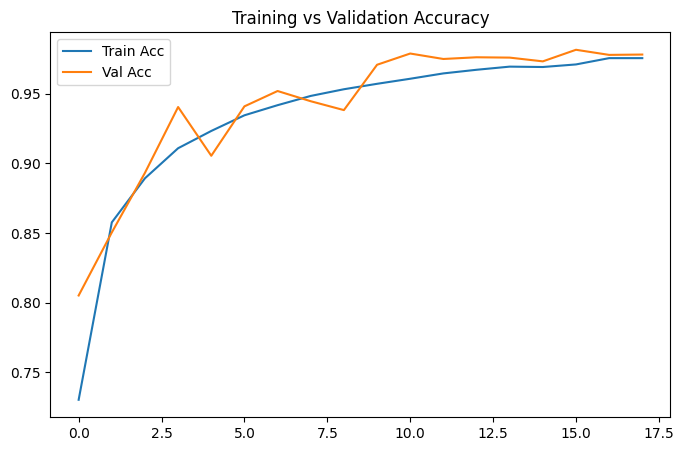

216/216 ━━━━━━━━━━━━━━━━━━━━ 57s 184ms/step


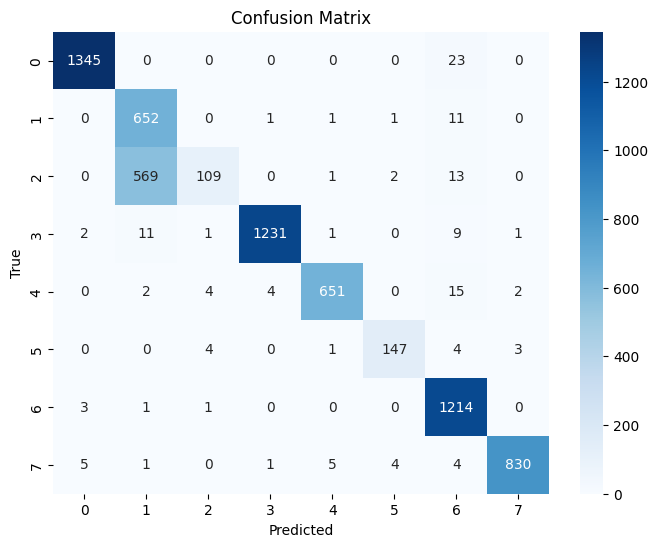

Classification Report:
                      precision    recall  f1-score   support

     bacterial spot       0.99      0.98      0.99      1368
       early blight       0.53      0.98      0.69       666
            healthy       0.92      0.16      0.27       694
        late blight       1.00      0.98      0.99      1256
          mold leaf       0.99      0.96      0.97       678
       mosaic virus       0.95      0.92      0.94       159
septorial leaf spot       0.94      1.00      0.97      1219
       yellow virus       0.99      0.98      0.98       850

           accuracy                           0.90      6890
          macro avg       0.91      0.87      0.85      6890
       weighted avg       0.93      0.90      0.88      6890



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Confusion matrix
preds = np.argmax(model.predict(test_gen), axis=1)
true_labels = test_gen.classes

cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:\n", classification_report(true_labels, preds, target_names=list(test_gen.class_indices.keys())))


In [ ]:
model.save("/content/drive/MyDrive/hybrid_densenet121_mobilenetv2_model.keras")
print("✅ Model saved to Drive!")


✅ Model saved to Drive!


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/hybrid_densenet121_mobilenetv2_model.keras"
model = load_model(model_path)

h5_path = "/content/drive/MyDrive/hybrid_densenet121_mobilenetv2_model.h5"
model.save(h5_path)

print("✅ Model converted to .h5 successfully!")
print("Saved at:", h5_path)
